# File and libraries

# DSLabs functions

In [125]:
%run "scripts/dslabs_functions.py"


# Data functions

In [126]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [127]:

import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"



# smoothed time series with split. uncomment to use
# train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)
# test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)




# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)




target='Sessions'

# Prepare the training and testing data
trnX = train.drop(columns=[target])
trnY = train[target]
tstX = test.drop(columns=[target])
tstY = test[target]

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 298 entries, 2024-01-05 to 2024-10-28
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         298 non-null    float64
 1   Seven-day active users           298 non-null    float64
 2   28-day active users              298 non-null    float64
 3   Events per session               298 non-null    float64
 4   Add to baskets                   298 non-null    float64
 5   Checkouts                        298 non-null    float64
 6   E-commerce purchases             298 non-null    float64
 7   Average purchase revenue         298 non-null    float64
 8   Purchase revenue                 298 non-null    float64
 9   Average session duration         298 non-null    float64
 10  ARPU                             298 non-null    float64
 11  ARPPU                            298 non-null    float64
 12  Vie

# ARIMA Univariate

## ARIMA Study

ARIMA (10, 1, 5) failed: LU decomposition error.
ARIMA best results achieved with (p,d,q)=(7, 2, 7) ==> measure=0.24


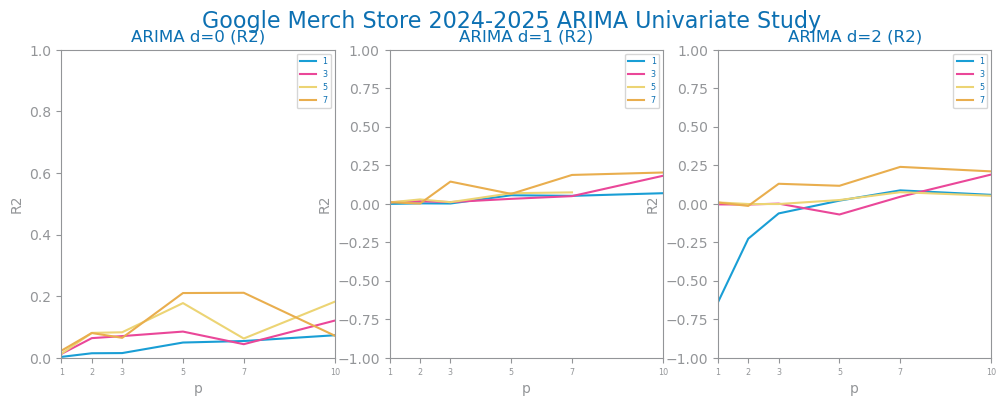

In [128]:
from matplotlib.pyplot import figure, savefig, subplots
import warnings
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import Series
from numpy import isfinite
from matplotlib.pyplot import savefig


def arima_uni_study(
    train: Series,
    test: Series,
    measure: str = "R2",
    freq: str = None,
    d_values: tuple = (0, 1, 2),
    p_params: tuple = (1, 2, 3, 5, 7, 10),
    q_params: tuple = (1, 3, 5, 7)):
    
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train)]
    test = test[isfinite(test)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)

    # d_values = (0, 1, 2)
    # p_params = (1, 2, 3, 5, 7, 10)
    # q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    fig.suptitle(f"{file_tag} ARIMA Univariate Study", fontsize=16)  # Add subtitle over the charts      
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    arima = ARIMA(train, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 100})  # Increase the number of iterations
                    prd_tst = model.forecast(steps=len(test), signal_only=False)
                    eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params


# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
# warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels")


measure='R2'

best_model, best_params = arima_uni_study(trnY, tstY, measure=measure, freq='D')
savefig(f"images/{file_tag}_arima_univariate_{measure}_study.png")

## ARIMA Model Creation

In [129]:
from statsmodels.tsa.arima.model import ARIMA


predictor = ARIMA(endog=trnY, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                  298
Model:                 ARIMA(7, 2, 7)   Log Likelihood                -276.352
Date:                Tue, 25 Mar 2025   AIC                            582.704
Time:                        17:58:06   BIC                            638.059
Sample:                    01-05-2024   HQIC                           604.867
                         - 10-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5107      4.584     -0.111      0.911      -9.495       8.474
ar.L2         -0.9262      2.213     -0.419      0.676      -5.264       3.411
ar.L3         -0.8686      6.468     -0.134      0.8

## ARIMA Model Plot Diagnostics

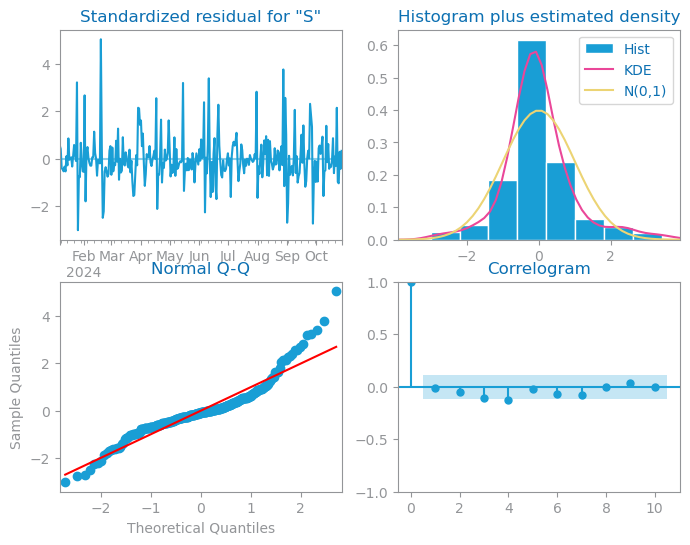

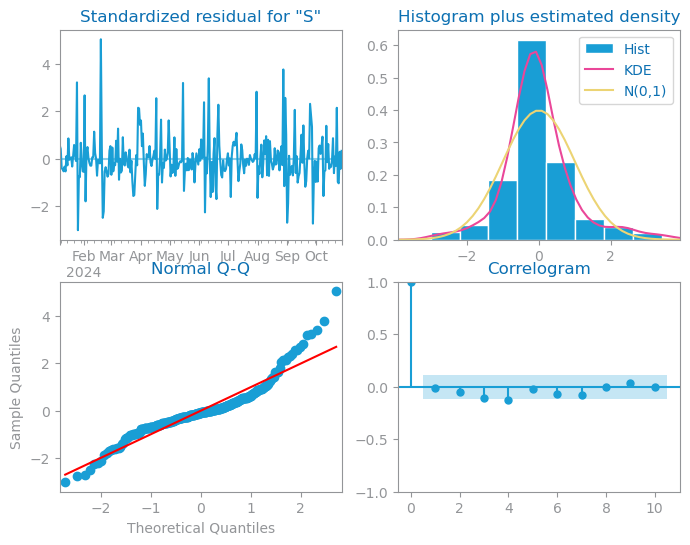

In [130]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Evaluate

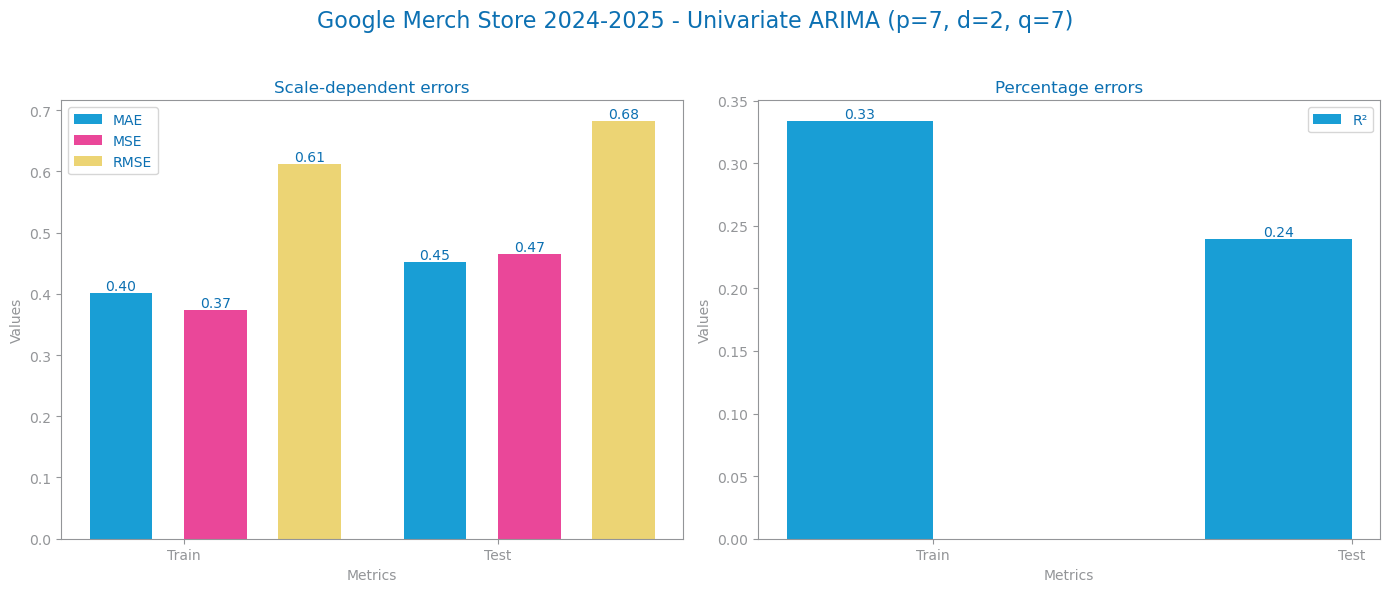

<Figure size 640x480 with 0 Axes>

In [131]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Univariate ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_univariate_eval.png")

## ARIMA Plot

<Axes: xlabel='Date', ylabel='Sessions'>

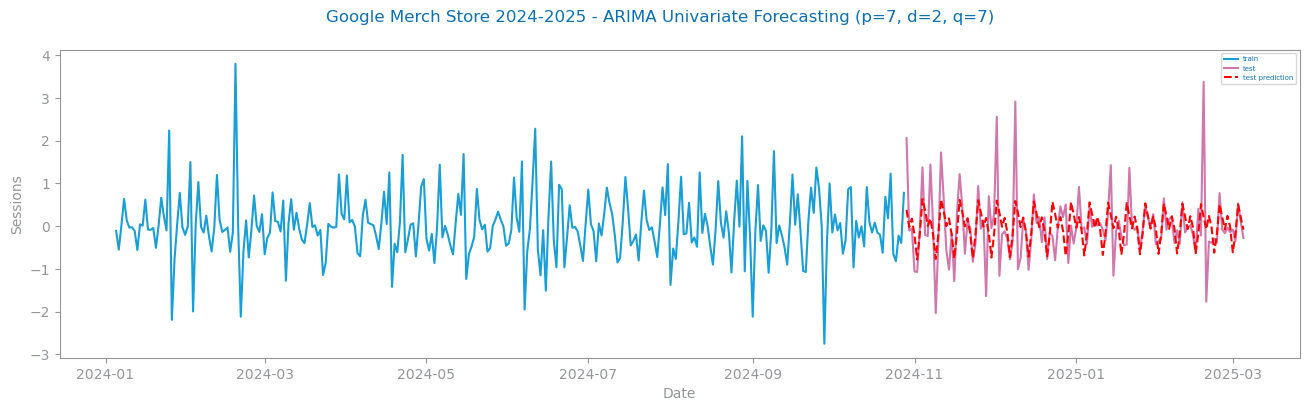

In [132]:
plot_forecasting_series(
    train[target],
    test[target],
    prd_tst,
    title=f"{file_tag} - ARIMA Univariate Forecasting (p={params[0]}, d={params[1]}, q={params[2]})",
    xlabel='Date',
    ylabel=target,
)

# ARIMA Multivariate

## ARIMA Multivariate Study

ARIMA best results achieved with (p,d,q)=(5, 1, 7) ==> measure=0.90


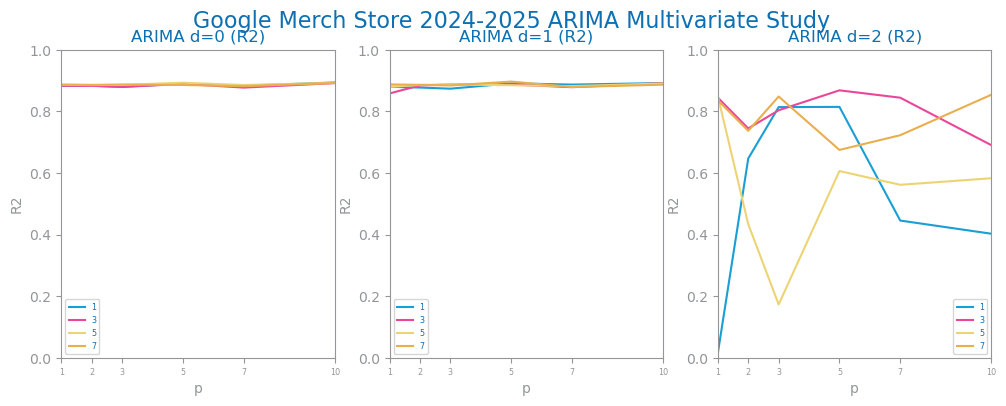

In [134]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from pandas import DataFrame
from numpy import isfinite
from statsmodels.tsa.arima.model import ARIMA
import warnings

def arima_multi_study(
    train: DataFrame,
    test: DataFrame,
    target: str, 
    measure: str = "R2",
    freq: str = None,
    d_values: tuple = (0, 1, 2),
    p_params: tuple = (1, 2, 3, 5, 7, 10),
    q_params: tuple = (1, 3, 5, 7)):
    
    # Ensure data does not contain NaN or infinite values
    train = train[isfinite(train).all(axis=1)]
    test = test[isfinite(test).all(axis=1)]

    # Set frequency if provided
    if freq:
        train = train.asfreq(freq)
        test = test.asfreq(freq)


    trnY = train.pop(target)
    tstY = test.pop(target)
    trnX = train
    tstX = test

    # d_values = (0, 1, 2)
    # p_params = (1, 2, 3, 5, 7, 10)
    # q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    fig.suptitle(f"{file_tag} ARIMA Multivariate Study", fontsize=16)  # Add subtitle over the charts   
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                try:
                    arima = ARIMA(endog=trnY, exog=trnX, order=(p, d, q))
                    model = arima.fit(method_kwargs={"maxiter": 50})  # Increase the number of iterations
                    prd_tst = model.forecast(steps=len(tstY), exog=tstX)
                    eval: float = FORECAST_MEASURES[measure](tstY, prd_tst)
                    # print(f"ARIMA ({p}, {d}, {q})", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (p, d, q)
                        best_model = model
                    yvalues.append(eval)
                except Exception as e:
                    print(f"ARIMA ({p}, {d}, {q}) failed: {e}")
                    yvalues.append(None)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

measure='R2'

best_model, best_params = arima_multi_study(train, test, target=target, measure=measure, freq='D')
savefig(f"images/{file_tag}_arima_multivariate_{measure}_study.png")

## ARIMA Multivariate Model

In [135]:
from statsmodels.tsa.arima.model import ARIMA

predictor = ARIMA(endog=trnY, exog=trnX, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:               Sessions   No. Observations:                  298
Model:                 ARIMA(5, 1, 7)   Log Likelihood                 113.163
Date:                Tue, 25 Mar 2025   AIC                           -110.326
Time:                        18:03:17   BIC                            103.911
Sample:                    01-05-2024   HQIC                           -24.559
                         - 10-28-2024                                         
Covariance Type:                  opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Seven-day active users              0.0409      0.046      0.888      0.374      -0.049       0.131
28-day active users                -0.0019      0.126     -0.015    

## ARIMA Multivariate Plot Diagnostics

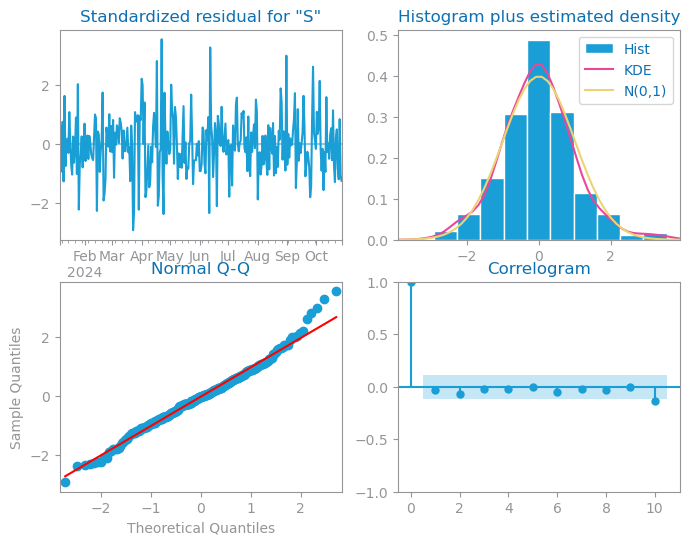

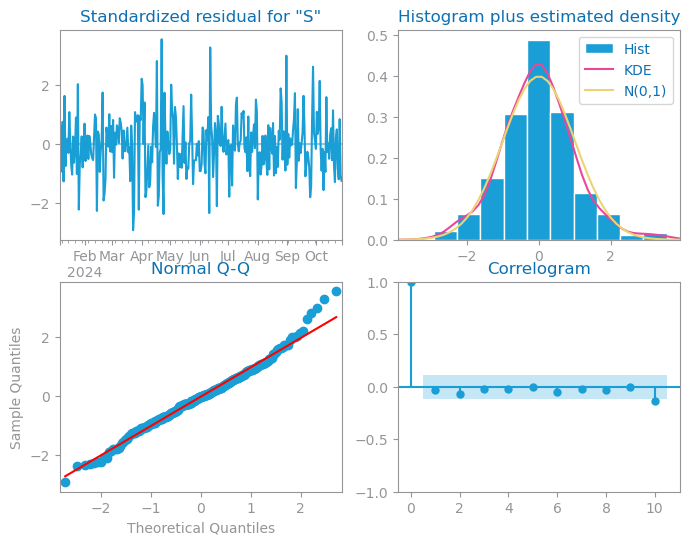

In [136]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Multivariate Evaluate

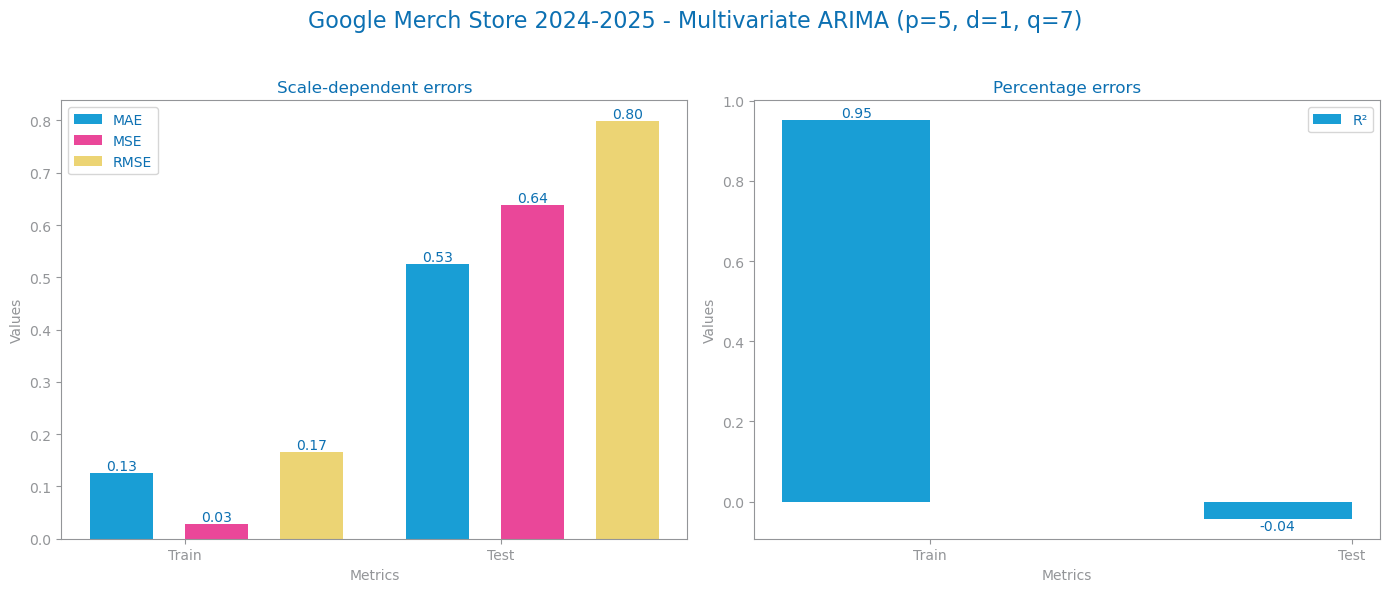

<Figure size 640x480 with 0 Axes>

In [137]:
from dslabs_functions import plot_forecasting_eval


params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)


# Prepare exogenous variables for forecasting
# Instead of using the last available exogenous variables, consider using a more representative approach
# For example, you can use the mean or median of the exogenous variables from the training set
exog_forecast = np.tile(trnX.mean(axis=0).values, (len(test), 1))

prd_tst = best_model.forecast(steps=len(test), exog=exog_forecast)

plot_single_model_evaluation(
    trnY, tstY, prd_trn, prd_tst, title=f"{file_tag} - Multivariate ARIMA (p={best_params["params"][0]}, d={best_params["params"][1]}, q={best_params["params"][2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_multivariate_eval.png")

## ARIMA Multivariate Plot

<Axes: xlabel='Date', ylabel='Sessions'>

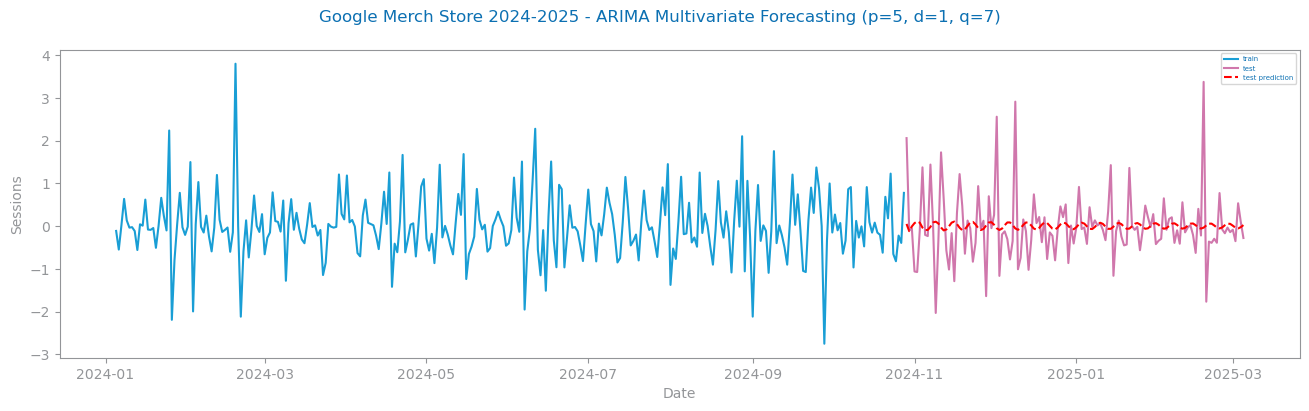

In [138]:
plot_forecasting_series(
    trnY,
    tstY,
    prd_tst,
    title=f"{file_tag} - ARIMA Multivariate Forecasting (p={best_params["params"][0]}, d={best_params["params"][1]}, q={best_params["params"][2]})",
    xlabel='Date',
    ylabel=target,
)

# ARIMA Multivariate with Lagged Features

## Arima multivariate lagged data prep

In [139]:


# smoothed time series with split. uncomment to use
# train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)
# test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)




# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)


def add_lagged_features(df, target, lags):
    """
    Add lagged features for the target variable based on the provided list of lags.

    Parameters:
    df (DataFrame): The input DataFrame.
    target (str): The target column name.
    lags (list): A list of integers representing the lag values.

    Returns:
    DataFrame: A new DataFrame with the target column and its lagged features.
    """
    df_lagged = df[[target]].copy()
    for lag in lags:
        df_lagged[f'{target}_lag{lag}'] = df[target].shift(lag)
    return df_lagged

# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
target = 'Sessions'
lags = [1, 7, 14]  # List of lags

# Add lagged features to the training and test sets
train_lagged = add_lagged_features(train, target, lags)
test_lagged = add_lagged_features(test, target, lags)





# Ensure all data is numeric
train_lagged = train_lagged.apply(pd.to_numeric)
test_lagged = test_lagged.apply(pd.to_numeric)

# drop any nan values
train_lagged.dropna(inplace=True)
test_lagged.dropna(inplace=True)


# Now you can use `train_lagged` and `test_lagged` in your ARIMA functions
print(train_lagged.head())


            Sessions  Sessions_lag1  Sessions_lag7  Sessions_lag14
Date                                                              
2024-01-19 -0.045206      -0.088033      -0.115394       -0.113015
2024-01-20 -0.507972      -0.045206      -0.559126       -0.548420
2024-01-21  0.007138      -0.507972       0.041637        0.023793
2024-01-22  0.661435       0.007138       0.010707        0.636452
2024-01-23  0.235547       0.661435       0.619797        0.133239


## ARIMA Multivariate Lagged Study

ARIMA best results achieved with (p,d,q)=(5, 2, 7) ==> measure=0.16


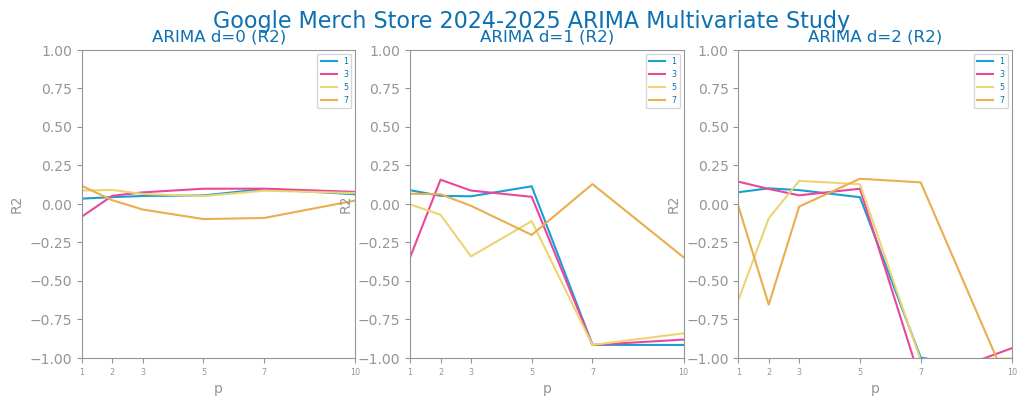

In [140]:

best_model, best_params = arima_multi_study(train_lagged, test_lagged, target=target, measure=measure, freq='D')


## ARIMA Multivariate Lagged Model

In [141]:

from statsmodels.tsa.arima.model import ARIMA

# Prepare data for ARIMA with lagged features
trnY_lagged = train_lagged.pop(target).values.astype(np.float32)
tstY_lagged = test_lagged.pop(target).values.astype(np.float32)
trnX_lagged = train_lagged.values.astype(np.float32)
tstX_lagged = test_lagged.values.astype(np.float32)


# Ensure best_params["params"] is correctly defined
if "params" not in best_params or len(best_params["params"]) < 3:
    raise ValueError("best_params['params'] must contain at least three elements for ARIMA order")

predictor = ARIMA(endog=trnY_lagged, exog=trnX_lagged, order=(best_params["params"][0], best_params["params"][1], best_params["params"][2]))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  284
Model:                 ARIMA(5, 2, 7)   Log Likelihood                -290.562
Date:                Tue, 25 Mar 2025   AIC                            613.125
Time:                        18:04:13   BIC                            671.395
Sample:                             0   HQIC                           636.492
                                - 284                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1467      0.105     -1.401      0.161      -0.352       0.058
x2             0.3541      0.081      4.369      0.000       0.195       0.513
x3             0.3056      0.065      4.720      0.0

## ARIMA Multivariate Lagged Plot Diagnostics

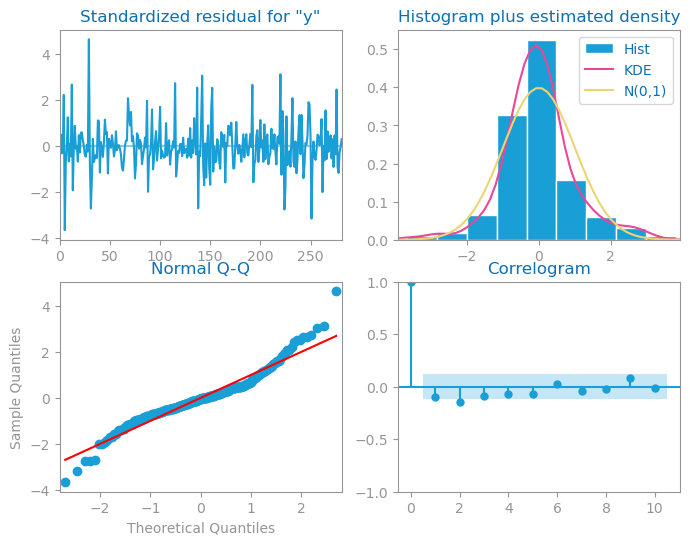

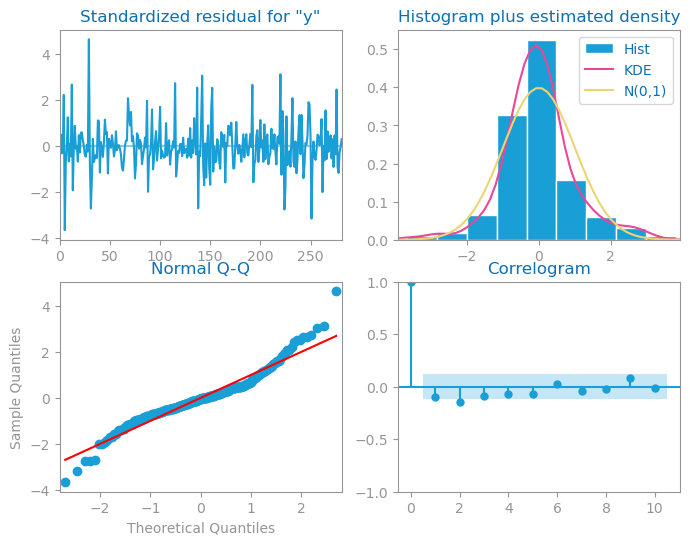

In [142]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))


## ARIMA Multivariate Lagged Evaluate

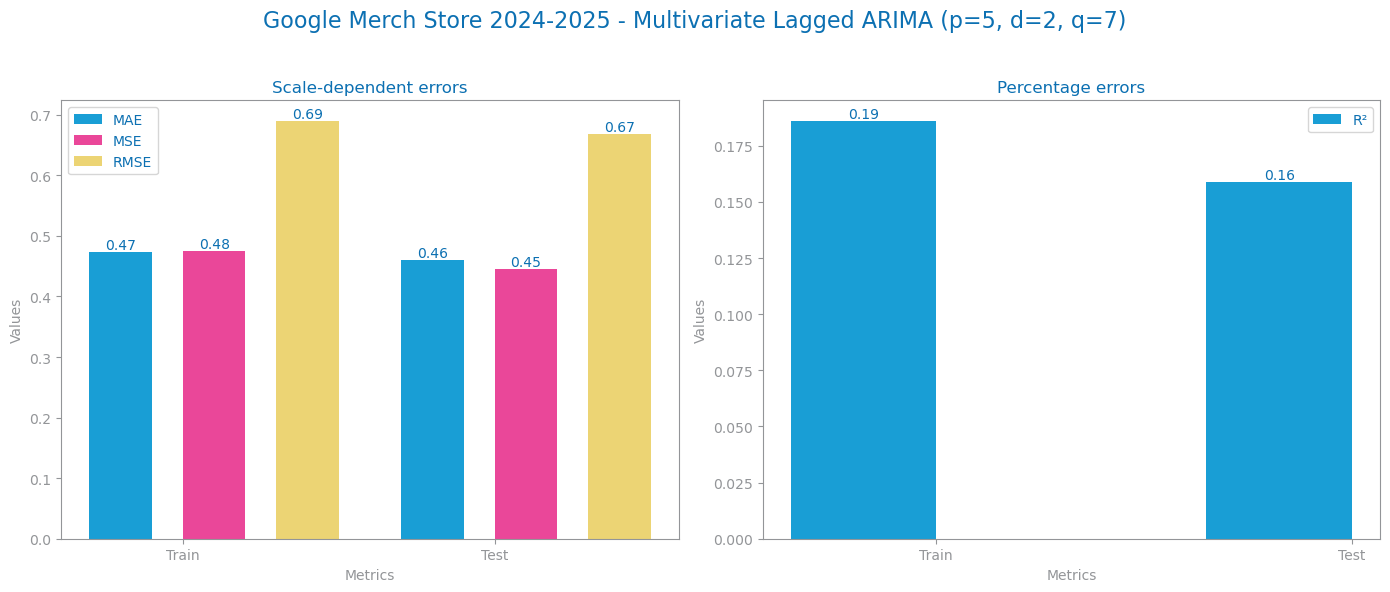

In [143]:

from dslabs_functions import plot_forecasting_eval


# Replace NaNs and infinite values with 0
# Create a mask for valid rows (no NaNs or infinite values)
valid_rows = ~np.isnan(trnX_lagged).any(axis=1) & ~np.isinf(trnX_lagged).any(axis=1)

# Filter trnX_lagged and trnY_lagged to keep only valid rows
trnX_lagged = trnX_lagged[valid_rows]
trnY_lagged = trnY_lagged[valid_rows]


# Make predictions
prd_trn = model.predict(start=0, end=len(trnY_lagged)-1, exog=trnX_lagged)
prd_tst = model.predict(start=len(trnY_lagged), end=len(trnY_lagged) + len(tstY_lagged) - 1, exog=tstX_lagged)


plot_single_model_evaluation(
    trnY_lagged, tstY_lagged, prd_trn, prd_tst, title=f"{file_tag} - Multivariate Lagged ARIMA (p={best_params["params"][0]}, d={best_params["params"][1]}, q={best_params["params"][2]})"
)

## ARIMA Multivariate Lagged Plot Forecast

<Axes: xlabel='Date', ylabel='Sessions'>

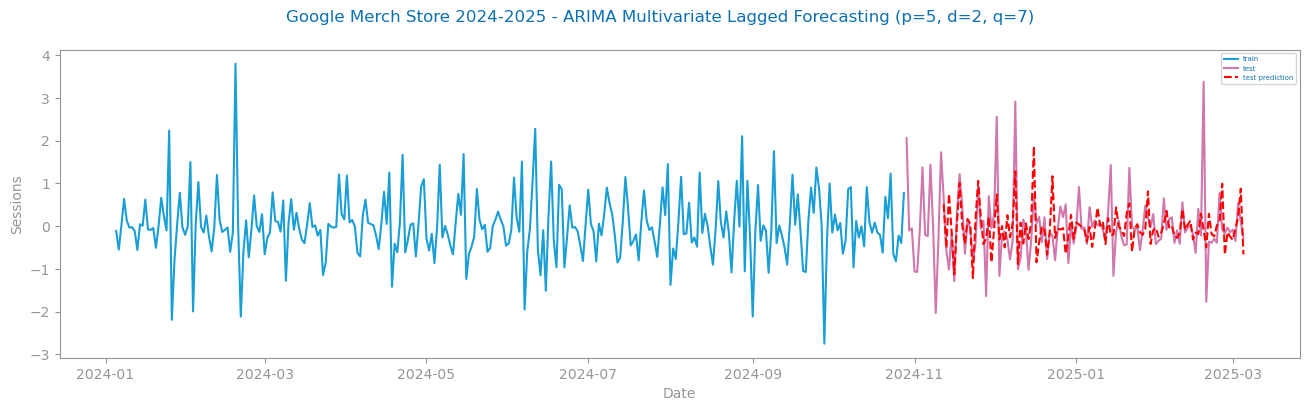

In [144]:
# Convert trnY_lagged and tstY_lagged to Pandas Series with appropriate indices
trnY_lagged_series = pd.Series(trnY_lagged, index=train_lagged.index[:len(trnY_lagged)])
tstY_lagged_series = pd.Series(tstY_lagged, index=test_lagged.index[:len(tstY_lagged)])

# Ensure prd_tst is also a Pandas Series with the same index as tstY_lagged
prd_tst_series = pd.Series(prd_tst, index=test_lagged.index[:len(prd_tst)])



plot_forecasting_series(
    trnY, 
    tstY, 
    prd_tst_series,
    title=f"{file_tag} - ARIMA Multivariate Lagged Forecasting (p={best_params["params"][0]}, d={best_params["params"][1]}, q={best_params["params"][2]})",
    xlabel='Date',
    ylabel=target,
)